<a href="https://colab.research.google.com/github/SriRamK345/Predicting-DoorDash-ETA-A-Machine-Learning-Approach/blob/main/Predicting_DoorDash_ETA_A_Machine_Learning_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Summary encapsulates a comprehensive data science workflow applied to predicting DoorDash delivery times.**

### **Data Preprocessing**
1. **Handling Missing Data**:
   - Rows with missing values and duplicates are removed, ensuring data integrity.
2. **Feature Engineering**:
   - Creation of new features like `delivery_duration_sec` and `free_dashers` to improve model insights and performance.
3. **Data Transformation**:
   - Conversion of date columns to datetime objects for temporal analysis.
   - Removal of unnecessary columns and outliers in the target variable to refine the dataset.

### **Exploratory Data Analysis (EDA)**
- Visual tools such as:
  - **Count plots**: For categorical data distribution.
  - **Scatter plots**: To examine relationships between variables.
  - **Heatmaps**: For correlation analysis.
- These provide insights into variable interactions and distributions.

### **Model Building and Evaluation**
1. **Data Preparation**:
   - Splitting data into training and testing sets.
   - Feature scaling with `MinMaxScaler` to standardize the feature range.
2. **Model Training**:
   - Models used: Linear Regression, Random Forest, XGBoost, and a Neural Network.
3. **Model Evaluation**:
   - Performance metrics include:
     - **R-squared**: Proportion of variance explained.
     - **MAE**, **MSE**, and **RMSE**: Indicators of prediction accuracy.

### **Model Selection and Deployment**
1. **Best Model Selection**:
   - The Neural Network outperformed others based on evaluation metrics.
2. **Model Saving and Deployment**:
   - Saved using `model.save()` for reuse.
   - A function enables loading the saved model and predicting new data seamlessly.

### **Conclusion**
This project effectively follows the data science pipeline:
- Data cleaning and transformation ensure robust input.
- EDA highlights key insights.
- Model building explores various algorithms.
- Deployment enables practical use of the Neural Network for accurate delivery time predictions.

This structured approach showcases expertise in handling end-to-end machine learning projects and can be applied to similar prediction tasks.

# Steps to get data sets from kaggle

In [1]:
! mkdir ~/.kaggle

In [2]:
! cp "/content/drive/MyDrive/kaggle.json" ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download dharun4772/doordash-eta-prediction

Dataset URL: https://www.kaggle.com/datasets/dharun4772/doordash-eta-prediction
License(s): MIT
  0% 0.00/4.99M [00:00<?, ?B/s]
100% 4.99M/4.99M [00:00<00:00, 149MB/s]


In [4]:
! unzip /content/doordash-eta-prediction.zip

Archive:  /content/doordash-eta-prediction.zip
  inflating: historical_data.csv     


# Import libraries

In [90]:
# Data cleaning
import pandas as pd
import numpy as np
# Visualization / EDA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# remove warnings
import warnings
warnings.filterwarnings("ignore")
# Split data for training and testing & Optimizing model parameters
from sklearn.model_selection import train_test_split
# Model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Model selection
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# Feature scaling
from sklearn.preprocessing import MinMaxScaler
# TenserFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Import dataset

In [6]:
df= pd.read_csv("/content/historical_data.csv")
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


## `Feature descriptions`

1. **market_id** - A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
2. **created_at** - When the order was submitted by the consumer to DoorDash.
3. **actual_delivery_time** - When the order was delivered
4. **store_id** - Representing the restaurant ID
5. **store_primary_category** - cuisine category of the restaurant
6. **order_protocol** - a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol.
7. **total_items** - total number of items in the order
8. **subtotal** - total value of the order submitted (in cents)
9. **num_distinct_items** - number of distinct items included in the order
10. **min_item_price** - price of the item with the least cost in the order (in cents)
11. **max_item_price** - max price of the item
12. **total_onshift_dashers:** The total number of delivery drivers who are currently available and actively working.
13. **total_busy_dashers:** The total number of delivery drivers who are currently occupied with delivering orders.
14. **total_outstanding_orders:** The total number of orders that have been placed but have not yet been delivered.
15. **estimated_order_place_duration:** The estimated time it takes for a customer to place an order.
16. **estimated_store_to_consumer_driving_duration:** The estimated time it takes for a delivery driver to travel from the store to the customer's location.

The target value to predict here is the total seconds value between created_at and actual_delivery_time.


# Exploring Data

In [7]:
df.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration'],
      dtype='object')

## Check for data types

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [9]:
df.shape

(197428, 16)

In [10]:
# Checking Null values

df.isnull().sum()

,0
market_id,987
created_at,0
actual_delivery_time,7
store_id,0
store_primary_category,4760
order_protocol,995
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0


In [115]:
# Checking Null values
print(f"There are {df.isnull().sum().sum()} null values in this dataset")

There are 0 null values in this dataset


#  Data Preprocessing

## Ratio of missing values

In [12]:
total_rows = df.shape[0]
total_missing_values = df.isnull().sum().sum()

if total_missing_values == 0:
    print("There are no missing values in the DataFrame.")
else:
    missing_values_ratio = total_rows / total_missing_values
    print(f"The ratio of total rows to missing values is: {missing_values_ratio:.2f}")

The ratio of total rows to missing values is: 3.52


**`The missing values is minimun so we can remove those from the dataset and dropping duplicate values`**

In [13]:
df.drop_duplicates(inplace=True) # to drop duplicate values
df.dropna(inplace=True) # to drop null values

In [14]:
# Get descriptive statistics to understand the distribution of numerical features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
market_id,175777.0,2.743726,1.330963,1.0,2.0,2.0,4.0,6.0
store_id,175777.0,3556.299561,2055.959006,1.0,1703.0,3620.0,5341.0,6987.0
order_protocol,175777.0,2.911752,1.513128,1.0,1.0,3.0,4.0,7.0
total_items,175777.0,3.204976,2.674055,1.0,2.0,3.0,4.0,411.0
subtotal,175777.0,2697.111147,1828.554893,0.0,1412.0,2224.0,3410.0,26800.0
num_distinct_items,175777.0,2.675060,1.625681,1.0,1.0,2.0,3.0,20.0
min_item_price,175777.0,684.965433,519.882924,-86.0,299.0,595.0,942.0,14700.0
max_item_price,175777.0,1160.158616,560.828571,0.0,799.0,1095.0,1395.0,14700.0
total_onshift_dashers,175777.0,44.918664,34.544724,-4.0,17.0,37.0,66.0,171.0
total_busy_dashers,175777.0,41.861381,32.168505,-5.0,15.0,35.0,63.0,154.0


In [15]:
print(df.describe(include='object'))  # Categorical columns

                 created_at actual_delivery_time store_primary_category
count                175777               175777                 175777
unique               162649               160269                     73
top     2015-02-11 19:50:43  2015-02-05 03:10:31               american
freq                      6                    5                  18183


###  Convert Date Columns

In [16]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Feature Engineering

In [17]:
# Calculate the delivery duration in seconds by subtracting the order creation time
# from the actual delivery time and extracting the total seconds.
df['delivery_duration_sec'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_sec
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0
15,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,2988.0


In [18]:
# Calculate the number of free dashers
df["free_dashers"] = df["total_onshift_dashers"] - df["total_busy_dashers"]
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_sec,free_dashers
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,19.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,-1.0
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0,2.0
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0,-1.0
15,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,2988.0,0.0


### Inference

`Could be able to see negative value in free_dashers column, Indicates there is no persons available to pick and deliver the order. Hence there was a delay in delivery.`

## Column Unique Values

In [19]:
unique_number = []
for i in df.columns:
    x = df[i].value_counts().count()
    unique_number.append(x)

pd.DataFrame(unique_number, index = df.columns, columns = ["Total Unique Values"])

,Total Unique Values
market_id,6
created_at,162649
actual_delivery_time,160269
store_id,5645
store_primary_category,73
order_protocol,7
total_items,54
subtotal,8182
num_distinct_items,20
min_item_price,2251


# EDA

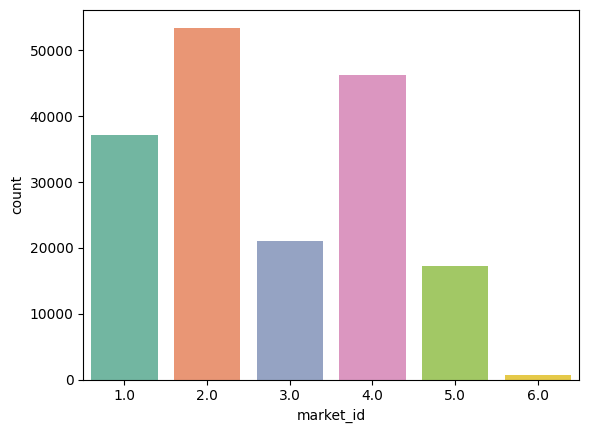

In [20]:
# Marlket Count
sns.countplot(x=df["market_id"], palette="Set2")
plt.show()

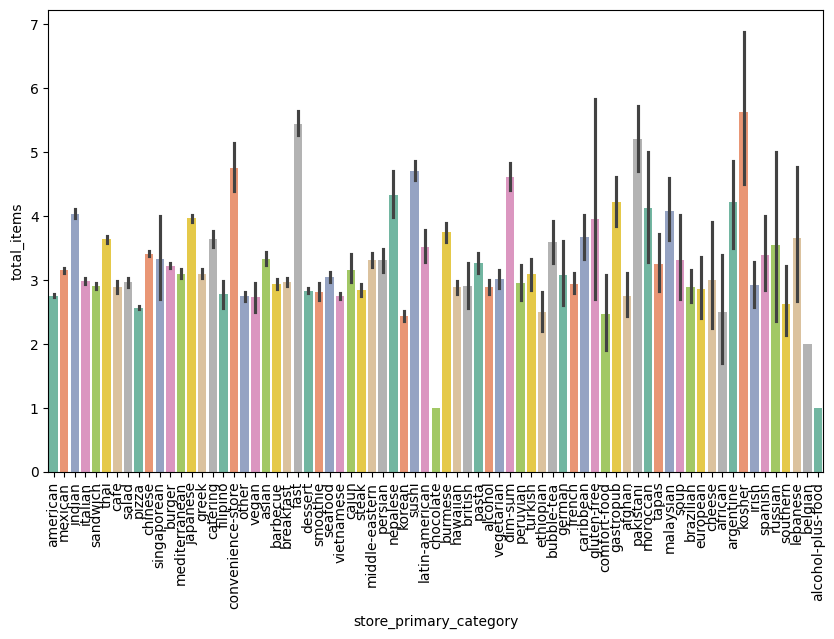

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["store_primary_category"], y=df["total_items"],palette="Set2")
plt.xticks(rotation=90)
plt.show()

`All cuisine category of the restaurant were sold well`

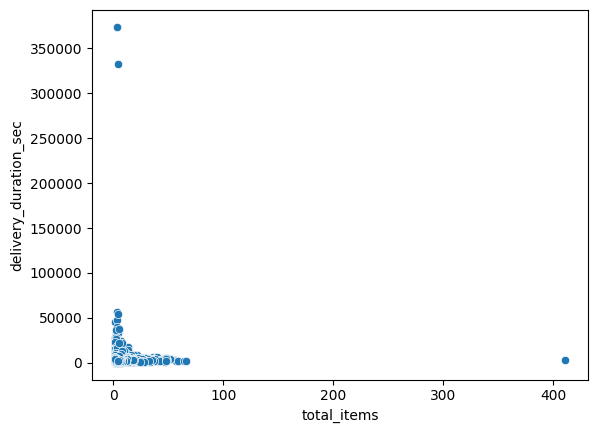

In [22]:
sns.scatterplot(x=df["total_items"], y=df["delivery_duration_sec"], palette="Set2")
plt.show()

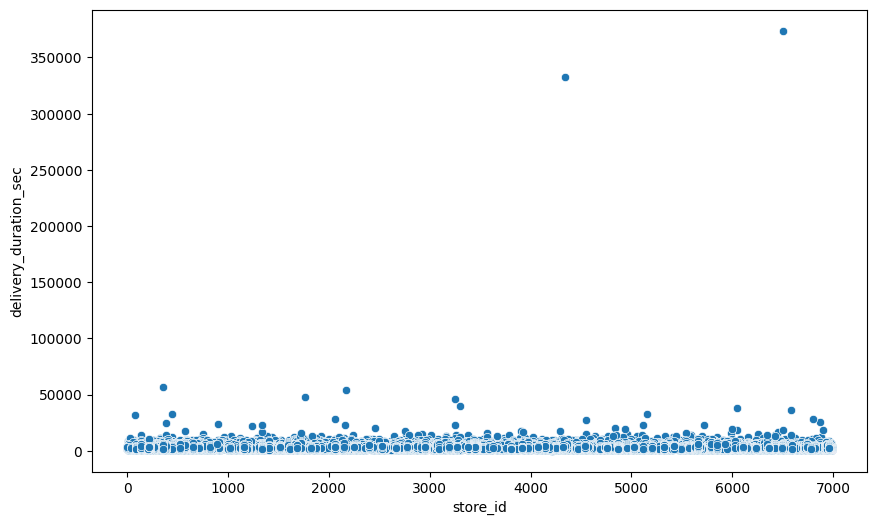

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["store_id"], y=df["delivery_duration_sec"], palette="railbow")
plt.show()

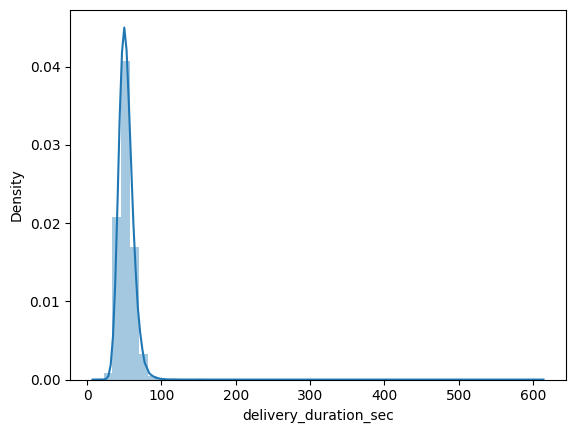

In [96]:
sns.distplot(np.sqrt(df["delivery_duration_sec"]))
plt.show()

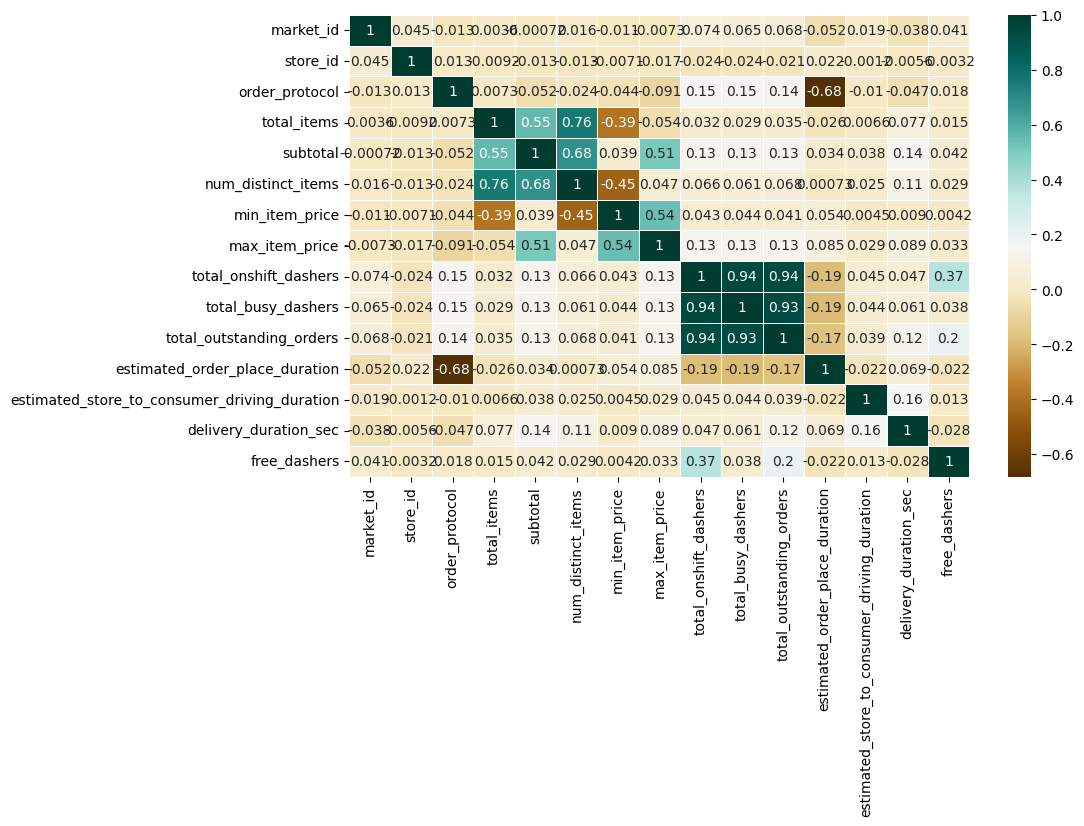

In [25]:
# heatmap

plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='BrBG',linewidths=0.5)
plt.show()

## Droping Outliers in Target column

In [111]:
drop_out= df[df["delivery_duration_sec"] > 10000]
print(len(drop_out))

df.drop(drop_out.index, inplace=True)

0


In [113]:
px.box(df, y="delivery_duration_sec")

## Removing Unwanted columns

In [26]:
df_copy = df.copy()

In [27]:
df_copy.drop(columns=["created_at","market_id", "store_id", "store_primary_category", "order_protocol","subtotal","num_distinct_items", "actual_delivery_time","min_item_price","max_item_price"], inplace=True)

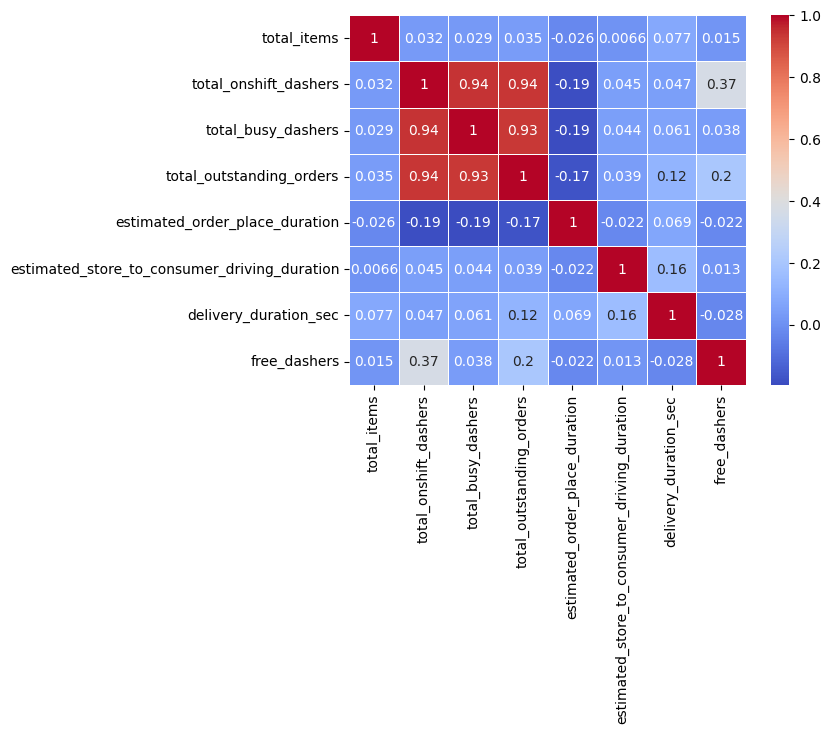

In [28]:
corr = df_copy.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm',linewidths=0.5)
plt.show()

# Train Test Split

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X = df_copy.drop("delivery_duration_sec", axis=1)
y = df_copy["delivery_duration_sec"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

# Feature Scaling

In [31]:
scale = MinMaxScaler()

X_train_s = scale.fit_transform(X_train)
X_test_s = scale.transform(X_test)

y_train_s = scale.fit_transform(y_train.values.reshape(-1, 1))
y_test_s = scale.transform(y_test.values.reshape(-1, 1))

# Pipeline

In [116]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

# Evaluation matrix

In [34]:
def evaluation_matrix(actual, pred):
  MAE = mean_absolute_error(actual, pred)
  MSE = mean_squared_error(actual, pred)
  RMSE = np.sqrt(mean_squared_error(actual, pred))
  SCORE = r2_score(actual, pred)
  return print("\n","r2_score:",SCORE , "\n","MAE:", MAE, "\n","MSE",MSE, "\n","RMSE", RMSE)

## 1. Linear Regression

In [35]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LinearRegression())])

In [36]:
lr_model_g = LinearRegression()
lr_model_g.fit(X_train_s, y_train_s)
y_pred_l = lr_model_g.predict(X_test_s)

train_score_LRg= lr_model_g.score(X_train_s,y_train_s)
test_score_LRg= lr_model_g.score(X_test_s,y_test_s)
print("Train Score LR", train_score_LRg)
print("Test Score LR", test_score_LRg)
evaluation_matrix(y_test_s, y_pred_l)

Train Score LR 0.07997135146391599
Test Score LR 0.1846134145040491

 r2_score: 0.1846134145040491 
 MAE: 0.0019367119269226233 
 MSE 7.776296942869714e-06 
 RMSE 0.002788601252038325


## 2. RandomForestRegressor

In [37]:
RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)
y_pred_r = RF_model.predict(X_test)

train_score_RF= RF_model.score(X_train,y_train)
test_score_RF= RF_model.score(X_test,y_test)
print("Train Score RF", train_score_RF)
print("Test Score RF", test_score_RF)

Train Score RF 0.7020757248818019
Test Score RF 0.015097606328920432


In [38]:
evaluation_matrix(y_test,y_pred_r)


 r2_score: 0.015097606328920432 
 MAE: 730.1273009671631 
 MSE 1312290.3598113742 
 RMSE 1145.5524256058184


## 3. XGBoost

In [39]:
xg_boost = XGBRegressor()
xg_boost.fit(X_train, y_train)
y_pred_x = xg_boost.predict(X_test)

train_score_xg= xg_boost.score(X_train,y_train)
test_score_xg= xg_boost.score(X_test,y_test)
print("Train Score XGB", train_score_xg)
print("Test Score XGB", test_score_xg)

Train Score XGB 0.40925106928484567
Test Score XGB 0.2007084498507239


In [40]:
evaluation_matrix(y_test,y_pred_x)


 r2_score: 0.2007084498507239 
 MAE: 695.5907567669092 
 MSE 1064981.2638082376 
 RMSE 1031.9792942730187


## Deep learning Model

In [41]:
def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(30, activation="relu", input_shape=input_shape),
        layers.Dropout(0.5),
        layers.Dense(15, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1)  # Output layer with 1 neuron for regression
    ])
    optimizer = tf.keras.optimizers.Adam(0.001) # optimizer

    model.compile(loss="mean_squared_error",
                  optimizer=optimizer,
                  metrics=["mae", "mse"])
    return model

In [42]:
input_shape = X_train_s.shape[1:]  # Input shape for the model

nn_model = build_model(input_shape) # Call function

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",  # Metric to monitor
    patience=4,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

# Train the model
history = nn_model.fit(X_train_s,
                           y_train_s,
                           epochs=1000,
                           validation_split=0.2, verbose=1,
                           callbacks=[early_stopping],
                           batch_size = 15)

Epoch 1/1000
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0029 - mae: 0.0155 - mse: 0.0029 - val_loss: 3.6482e-05 - val_mae: 0.0023 - val_mse: 3.6482e-05
Epoch 2/1000
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 2.2879e-05 - mae: 0.0023 - mse: 2.2879e-05 - val_loss: 3.6392e-05 - val_mae: 0.0022 - val_mse: 3.6392e-05
Epoch 3/1000
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 2.1488e-05 - mae: 0.0023 - mse: 2.1488e-05 - val_loss: 3.6371e-05 - val_mae: 0.0022 - val_mse: 3.6371e-05
Epoch 4/1000
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 1.5658e-05 - mae: 0.0023 - mse: 1.5658e-05 - val_loss: 3.6373e-05 - val_mae: 0.0022 - val_mse: 3.6373e-05
Epoch 5/1000
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 1.2385e-05 - mae: 0.0023 - mse: 1.2385e-05 - val_loss: 3.6619e-05 - val_mae: 0.0022 - val_mse: 3.6619e-05
Epoch 6/1000
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 1.1227e-05 - mae: 0.0023 - mse: 1.1227e-05 - val_loss: 3.6476e-05 - val_mae: 0.0023 - va

## Evaluate the NN model

In [85]:
loss, mae, mse= nn_model.evaluate(X_test_s, y_test_s, verbose=0)
print("Testing set Mean Abs Error: {:.3f} ".format(mae))
print("Testing set Mean Squared Error: {:.3f}".format(mse))
print("Testing set Root Mean Squared Error: {:.3f}".format(np.sqrt(mse)))

Testing set Mean Abs Error: 0.002 
Testing set Mean Squared Error: 0.000
Testing set Root Mean Squared Error: 0.003


In [86]:
y_pred = nn_model.predict(X_test_s)
evaluation_matrix(y_test_s, y_pred)

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

 r2_score: -1.0614863866775792e-05 
 MAE: 0.002201179752924067 
 MSE 9.537046139253373e-06 
 RMSE 0.003088210831412482


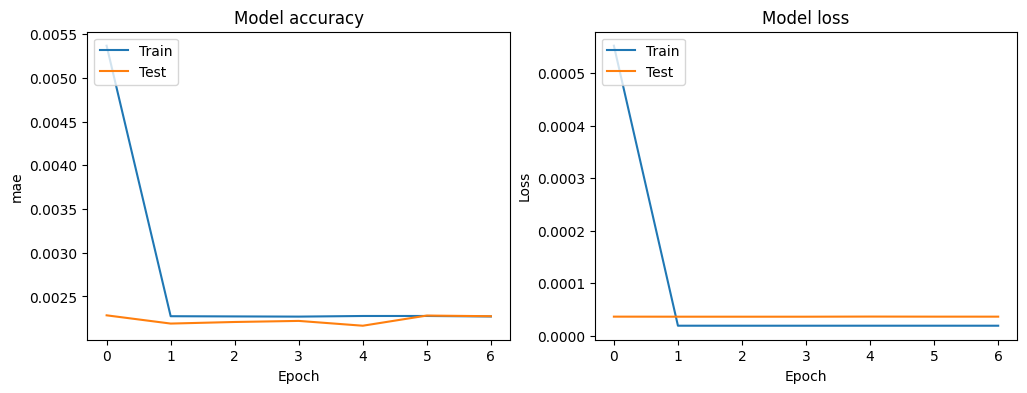

In [45]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model accuracy')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Saving the Neural network model

In [47]:
nn_model.save('model.keras')

# Loading the saved model and prediction

In [48]:
Model = tf.keras.models.load_model('model.keras')

In [77]:
total_items = int(input("Enter total_items: "))
total_onshift_dashers = int(input("Enter total_onshift_dashers: "))
total_busy_dashers = int(input("Enter total_busy_dashers: "))
total_outstanding_orders = int(input("Enter total_outstanding_orders: "))
estimated_order_place_duration = int(input("Enter estimated_order_place_duration: "))
estimated_store_to_consumer_driving_duration = int(input("Enter estimated_store_to_consumer_driving_duration: "))
free_dashers = int(input("Enter free_dashers: "))

Enter total_items: 8
Enter total_onshift_dashers: 12
Enter total_busy_dashers: 2
Enter total_outstanding_orders: 52
Enter estimated_order_place_duration: 21
Enter estimated_store_to_consumer_driving_duration: 235
Enter free_dashers: 3


In [78]:
input_data = np.array([[total_items, total_onshift_dashers, total_busy_dashers, total_outstanding_orders, estimated_order_place_duration, estimated_store_to_consumer_driving_duration, free_dashers]])

In [89]:
def prediction(*input_data):
  input_data = np.array([input_data])
  prediction = Model.predict(input_data)
  delivery_duration_sec = scale.inverse_transform(prediction)
  return abs(delivery_duration_sec[0][0])

print("Total seconds to deliver",prediction(total_items, total_onshift_dashers, total_busy_dashers, total_outstanding_orders, estimated_order_place_duration, estimated_store_to_consumer_driving_duration, free_dashers),"sec")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Total seconds to deliver 3210759.8 sec
